In [1]:
from jaxosqp import osqp
import jax
import jax.numpy as jnp
from jax import random

from jax.experimental import sparse

%load_ext autoreload
%autoreload 2

In [23]:
# Generate some random problem data.
B = 100
n = 50
m = 200

outer = lambda A: A @ A.T + 1e-2 * sparse.eye(n)
key = random.PRNGKey(208)
key, subkey = random.split(key)
P = sparse.random_bcoo(key, (B, n, n), nse=0.95, n_batch=1, generator=random.normal).todense()
P = jax.vmap(outer)(P) # Ensure P >= 0.

key, subkey = random.split(key)
q = random.normal(subkey, (B, n))
key, subkey = random.split(key)

# Add some random constraints (a la OSQP benchmarks
A = sparse.random_bcoo(subkey, (B, m, n), nse=0.95, n_batch=1, generator=random.normal).todense()
key, subkey = random.split(key)
l = -random.uniform(subkey, (B, m))
key, subkey = random.split(key)
u = random.uniform(subkey, (B, m))

In [24]:
def solve_osqp(P, q, A, l, u):
    prob, data, state = osqp.OSQPProblem.from_data(P, q, A, l, u)
    return jax.vmap(prob.solve)(data, state)[-1].x.block_until_ready()

# %timeit sol_mine = solve_osqp(P, q, A, l, u)

prob, data, state = osqp.OSQPProblem.from_data(P, q, A, l, u)
sol = jax.vmap(sparse.sparsify(prob.solve))(data, state)
%timeit solve_osqp(P, q, A, l, u)

78.3 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [307]:
# %time sol = jax.vmap(prob.solve)(data, state)
sol_jitd = jax.jit(jax.vmap(prob.solve))
sol_sparse_jitd = jax.jit(jax.vmap(sparse.sparsify(prob.solve)))

sol_jitd(data, state)
sol_sparse_jitd(data, state)

(Array([0, 0, 0, ..., 0, 0, 0], dtype=int32, weak_type=True),
 OSQPData(P=Array([[[ 1.        ,  0.29094326,  0.4284288 , -0.34115893,
          -0.13439813],
         [ 0.29094326,  1.        , -0.37179992,  0.2923568 ,
           0.10243393],
         [ 0.42842877, -0.37179995,  1.        , -0.4718293 ,
           0.53118366],
         [-0.34115896,  0.2923568 , -0.47182932,  0.9999999 ,
           0.2352445 ],
         [-0.13439815,  0.10243393,  0.53118366,  0.2352445 ,
           1.        ]],
 
        [[ 0.9999999 ,  0.31993186,  0.12916589, -0.8673883 ,
           0.00755942],
         [ 0.31993178,  0.5342728 , -0.32173502, -0.43970987,
          -0.03762052],
         [ 0.12916589, -0.3217351 ,  0.6585733 , -0.1761025 ,
          -0.23804316],
         [-0.8673883 , -0.43970987, -0.17610252,  0.9999999 ,
           0.34611914],
         [ 0.00755942, -0.03762053, -0.23804317,  0.34611917,
           0.7202737 ]],
 
        [[ 1.        ,  0.81315273, -0.02081607, -0.696986  ,

In [22]:
prob, data, state = osqp.OSQPProblem.from_data(P, q, A, l, u)
%time state = jax.vmap(prob.solve)(data, state)[-1]
%time state = jax.vmap(prob.solve)(data, state)[-1]

CPU times: user 2.33 s, sys: 18.2 ms, total: 2.35 s
Wall time: 2.04 s
CPU times: user 2.16 ms, sys: 141 µs, total: 2.3 ms
Wall time: 2.25 ms


In [310]:
prob, data, state = osqp.OSQPProblem.from_data(P, q, A, l, u)
%time sol_jitd(data, state)
%time sol_sparse_jitd(data, state)

CPU times: user 120 ms, sys: 0 ns, total: 120 ms
Wall time: 120 ms
CPU times: user 118 ms, sys: 27 µs, total: 118 ms
Wall time: 118 ms


(Array([26, 26, 26, ..., 26, 51, 26], dtype=int32, weak_type=True),
 OSQPData(P=Array([[[ 1.        ,  0.29094326,  0.4284288 , -0.34115893,
          -0.13439813],
         [ 0.29094326,  1.        , -0.37179992,  0.2923568 ,
           0.10243393],
         [ 0.42842877, -0.37179995,  1.        , -0.4718293 ,
           0.53118366],
         [-0.34115896,  0.2923568 , -0.47182932,  0.9999999 ,
           0.2352445 ],
         [-0.13439815,  0.10243393,  0.53118366,  0.2352445 ,
           1.        ]],
 
        [[ 0.9999999 ,  0.31993186,  0.12916589, -0.8673883 ,
           0.00755942],
         [ 0.31993178,  0.5342728 , -0.32173502, -0.43970987,
          -0.03762052],
         [ 0.12916589, -0.3217351 ,  0.6585733 , -0.1761025 ,
          -0.23804316],
         [-0.8673883 , -0.43970987, -0.17610252,  0.9999999 ,
           0.34611914],
         [ 0.00755942, -0.03762053, -0.23804317,  0.34611917,
           0.7202737 ]],
 
        [[ 1.        ,  0.81315273, -0.02081607, -0.696

Text(0, 0.5, 'solve time (batch of 100), ms')

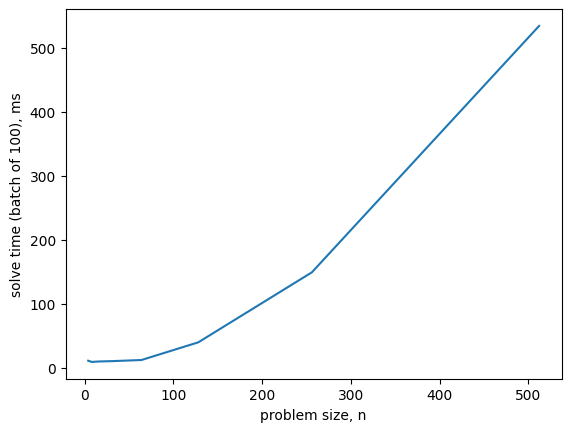

In [280]:
n_vals = [4, 8, 16, 32, 64, 128, 256, 512]
times = [10.9, 9.01, 9.7, 10.3, 12, 39.6, 149, 534]

from matplotlib import pyplot as plt

plt.plot(n_vals, times)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('problem size, n')
plt.ylabel('solve time (batch of 100), ms')

In [238]:
with jax.profiler.trace("/tmp/tensorboard"):
    prob, data, state = osqp.OSQPProblem.from_data(P, q, A, l, u)
    sol_mine = jax.vmap(prob.solve)(data, state)

In [317]:
prob, data, state = osqp.OSQPProblem.from_data(P, q, A, l, u)
sol_mine = jax.vmap(prob.solve)(data, state)

In [77]:
from matplotlib import pyplot as plt

plt.hist(sol[0], bins=8)
plt.title(f'Histogram of solve times, n={n}, B={B}, m={m}')
plt.xlabel('Number of iterations')
plt.ylabel('Freq')

TypeError: 'OSQPState' object is not subscriptable

In [162]:
A = sparse.random_bcoo(key, (5, 2, 2), nse=0.15, n_batch=1, generator=random.normal)
sum_x = jax.vmap(sparse.sparsify(lambda x: jnp.sum(x @ x.T + sparse.eye(2))))

sum_x(A)

Array([2.005999 , 2.1144671, 2.004582 , 2.5526845, 2.1723697], dtype=float32)

In [58]:
import jax_dataclasses as jdc

@jdc.pytree_dataclass
class Foo:
    x: jnp.ndarray
    y: jnp.ndarray
    z: jdc.Static[int]
    
def sumup(foo):
    return foo.x + foo.y

bar = Foo(jnp.ones((2, 5)), jnp.ones((2, 5)), 3)
jax.vmap(sumup)(bar)

Array([[2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2.]], dtype=float32)

In [108]:
A_sparse = sparse.random_bcoo(subkey, (B, m, n), nse=0.01, n_batch=1, generator=random.normal)
A = A_sparse.todense()

# Define jit'd matrix-vector product (vmap across batch dim)
bmm = jax.jit(jax.vmap(sparse.sparsify(lambda A, x: A @ x)))

# Run it once to compile
bmm(A, state.x)
bmm(A_sparse, state.x)

# Time dense / sparse naive calls
%timeit bmm(A, state.x) # 23.1 µs ± 1.59 µs per loop
%timeit bmm(A_sparse, state.x) # 32.6 µs ± 2.2 µs per loop

# jit a low-level matmul
bmm_sp = lambda A, x: sparse.bcoo_dot_general(A, x, dimension_numbers=((2, 1), (0,0)))
jitbmmsp = jax.jit(bmm_sp) 

jitbmmsp(A_sparse, state.x) # Run to compile
%timeit jitbmmsp(A_sparse, state.x) # 30.1 µs ± 2.02 µs per loop

23.8 µs ± 3.7 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
33.9 µs ± 2.21 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
32.5 µs ± 4.73 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [109]:
A_sparse.shape

(10, 1000, 100)

In [182]:
times

NameError: name 'times' is not defined

In [62]:
import osqp as oo
import numpy as np
import scipy 

B, m, n = A.shape

results = []
probs = []

def setup_all(probs):
    for ii in range(B):
        m = oo.OSQP()
        m.setup(P=scipy.sparse.csc_matrix(np.asarray(P[ii, :, :])), q=np.asarray(q[ii,:]), A=scipy.sparse.csc_matrix(np.asarray(A[ii, :, :])), l=np.asarray(l[ii, :]), u=np.asarray(u[ii,:]), verbose=False)
        probs.append(m)

def solve_all(probs, results):
    solve_time = 0.
    for m in probs:
        results.append(m.solve())
        solve_time += results[-1].info.setup_time + results[-1].info.solve_time
        
    return solve_time
setup_all(probs)
%time solve_time = solve_all(probs, results)

1000 * solve_time

CPU times: user 24 µs, sys: 0 ns, total: 24 µs
Wall time: 31.5 µs


0.024569

In [63]:
results = []
%time solve_time = solve_all(probs, results)
osqp_iters = [rr.info.iter for rr in results]

CPU times: user 175 µs, sys: 11 µs, total: 186 µs
Wall time: 167 µs


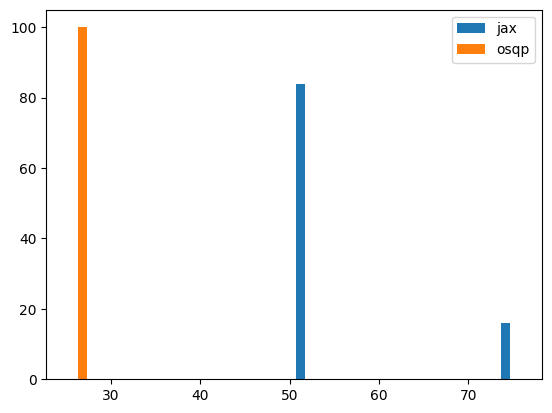

In [28]:
from matplotlib import pyplot as plt

plt.close("all")
fig, ax = plt.subplots()
ax.hist([sol[0], osqp_iters], label=['jax', 'osqp'], bins=20)
# ax.hist(, bins=10, range=(0, max(sol[0])), label='osqp', alpha=0.5)
ax.legend()

In [39]:
from jaxopt import BoxOSQP

qp = BoxOSQP(jit=True)
solve_qp = jax.jit(jax.vmap(lambda P, q, A, l, u: qp.run(params_obj=(P, q), params_eq=A, params_ineq=(l,u)).params))

sol = solve_qp(P, q, A, l, u)
%timeit sol = solve_qp(P, q, A, l, u)

sol_mine[-1].x - sol.primal[0]

3.34 s ± 81.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


NameError: name 'sol_mine' is not defined

In [249]:
osqp_iters = jnp.array(osqp_iters)
my_iters = sol[0]

print(f"osqp stats | mean: {jnp.mean(osqp_iters)}, median: {jnp.median(osqp_iters)}, std: {jnp.std(osqp_iters)}, max: {jnp.max(osqp_iters)}")
print(f"my stats | mean: {jnp.mean(my_iters)}, median: {jnp.median(my_iters)}, std: {jnp.std(my_iters)}, max: {jnp.max(my_iters)}")

osqp stats | mean: 29.97749900817871, median: 25.0, std: 16.81255340576172, max: 500
my stats | mean: 21.987499237060547, median: 26.0, std: 16.969453811645508, max: 626


Array(True, dtype=bool)

In [65]:
# Bug hunting
P = jnp.array([[[0.61585732]]])
q = jnp.array([[0.1930774]])
A = jnp.array([[[0.00870719]]])
l = jnp.array([[-0.1864503]])
u = jnp.array([[0.88669298]])

prob, data, state = osqp.OSQPProblem.from_data(P, q, A, l, u)
sol = jax.vmap(prob.solve)(data, state)
sol[-1].z

jax_obj = 0.5 * jnp.dot(sol[-1].x[0], P[0] @ sol[-1].x[0]) + jnp.dot(q[0], sol[-1].x[0])
osqp_obj = 0.5 * np.dot(results[0].x, P[0] @ results[0].x) + np.dot(q[0], results[0].x)

jax_obj - osqp_obj

Array(0.00140209, dtype=float32)